# ***Machine Learning for Predicting Epileptic Seizures Using EEG Signals***

1. Installing the mne

In [5]:
%%capture
pip install mne

2. Importing the Dependencies

In [6]:
from glob import glob as g
import numpy as n
import pandas as p
import mne
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from IPython.display import display
from google.colab import drive as d
from scipy import stats

3. Connecting and importing datas from google drive

In [7]:
d.mount('/content/drive')
imported_files = sorted(g('/content/drive/MyDrive/Engineering_Project_1/Data/*.edf'))
print("Total EDF files found:", len(imported_files))
#print("Example:", imported_files[:3])

Mounted at /content/drive
Total EDF files found: 115


4. Dictionary containing information about files with seizures

In [8]:
seizure_dict = {
    'chb01_03.edf': [(2996, 3036)],
    'chb01_04.edf': [(1467, 1494)],
    'chb01_15.edf': [(1732, 1772)],
    'chb01_16.edf': [(1015, 1066)],
    'chb01_18.edf': [(1720, 1810)],
    'chb01_21.edf': [(327, 420)],
    'chb01_26.edf': [(1862, 1963)],
    'chb02_16.edf': [(130, 212)],
    'chb02_16+.edf': [(2972, 3053)],
    'chb02_19.edf': [(3369, 3378)],
    'chb03_01.edf': [(362, 414)],
    'chb03_02.edf': [(731, 796)],
    'chb03_03.edf': [(432, 501)],
    'chb03_04.edf': [(2162, 2214)],
    'chb03_34.edf': [(1982, 2029)],
    'chb03_35.edf': [(2592, 2656)],
    'chb03_36.edf': [(1725, 1778)],
    'chb04_05.edf': [(7804, 7853)],
    'chb03_01.edf': [(362, 414)],
    'chb03_02.edf': [(731, 796)],
    'chb03_03.edf': [(432, 501)],
    'chb03_04.edf': [(2162, 2214)],
    'chb03_34.edf': [(1982, 2029)],
    'chb03_35.edf': [(2592, 2656)],
    'chb03_36.edf': [(1725, 1778)],
    'chb04_05.edf': [(7804, 7853)],
    'chb04_08.edf': [(6446, 6557)],
    'chb04_28.edf': [(1679, 1781), (3782, 3898)],
    'chb05_06.edf': [(417, 532)],
    'chb05_13.edf': [(1086, 1196)],
    'chb05_16.edf': [(2317, 2413)],
    'chb05_17.edf': [(2451, 2571)],
    'chb05_22.edf': [(2348, 2465)]
}

5. Assigning labels for files with seiure and no seizure

In [9]:
data_info = []
seizure_info=[]
seizure_files = []
for file in imported_files:
    filename = file.split('/')[-1]
    if filename in seizure_dict:
      seizure_files.append(file)
      label="Seizure Detected"
      start, end = seizure_dict[filename][0]
      #print(filename, start,end)
      seizure_info.append({'filename': filename, 'filepath': file, 'starting time':start, 'ending time':end})
    else:
      label= "No Seizure Detected"
      start=0
      end=0
    data_info.append({'filename': filename, 'filepath': file, 'label': label})

df_info = p.DataFrame(data_info)
seizure_info=p.DataFrame(seizure_info)
#print(df_info)
#print("\nFile Information:\n")
#print(df_info)


6. Define function to extract features

In [10]:
def extract_features(file_path, start_time=None, end_time=None):
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    raw.filter(0.5, 45, verbose=False)

    if start_time is not None and end_time is not None:
        # Select data within the specified time window
        raw.crop(tmin=start_time, tmax=end_time, include_tmax=True)

    epochs = mne.make_fixed_length_epochs(raw, duration=5, preload=True, verbose=False)
    data = epochs.get_data()

    # Calculate features for each epoch and then average across epochs
    mean = n.mean(data, axis=2)
    std = n.std(data, axis=2)
    power = n.mean(data ** 2, axis=2)
    ptp = n.ptp(data,axis=2)
    var = n.var(data,axis=2)
    maxim = n.max(data,axis=2)
    minim = n.min(data,axis=2)
    arg_min = n.argmin(data,axis=2)
    arg_max = n.argmax(data,axis=2)
    rms = n.sqrt(n.mean(data**2,axis=2))
    abs_diff_signal = n.sum(n.abs(n.diff(data,axis=2)), axis=1) / (data.shape[1] - 1)
    skewness = stats.skew(data,axis=2)
    kurt = stats.kurtosis(data,axis=2)

    # Average the features across all epochs
    mean_avg = n.mean(mean, axis=0)
    std_avg = n.mean(std, axis=0)
    power_avg = n.mean(power, axis=0)
    ptp_avg = n.mean(ptp, axis=0)
    var_avg = n.mean(var, axis=0)
    maxim_avg = n.mean(maxim, axis=0)
    minim_avg = n.mean(minim, axis=0)
    arg_min_avg = n.mean(arg_min, axis=0)
    arg_max_avg = n.mean(arg_max, axis=0)
    rms_avg = n.mean(rms, axis=0)
    abs_diff_signal_avg = n.mean(abs_diff_signal, axis=0)
    skewness_avg = n.mean(skewness, axis=0)
    kurt_avg = n.mean(kurt, axis=0)


    # Combine all averaged features into one vector
    features = n.concatenate([mean_avg, std_avg, power_avg, ptp_avg, var_avg, maxim_avg, minim_avg, arg_min_avg, arg_max_avg, rms_avg, kurt_avg,skewness_avg, abs_diff_signal_avg])
    return features

7. Visualization of Files with Seizures

/tmp/ipython-input-289529150.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=False)


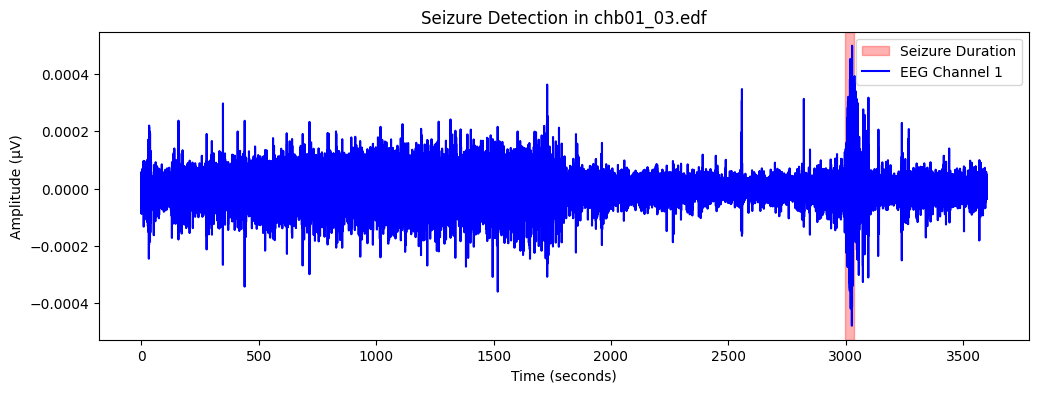

/tmp/ipython-input-289529150.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=False)


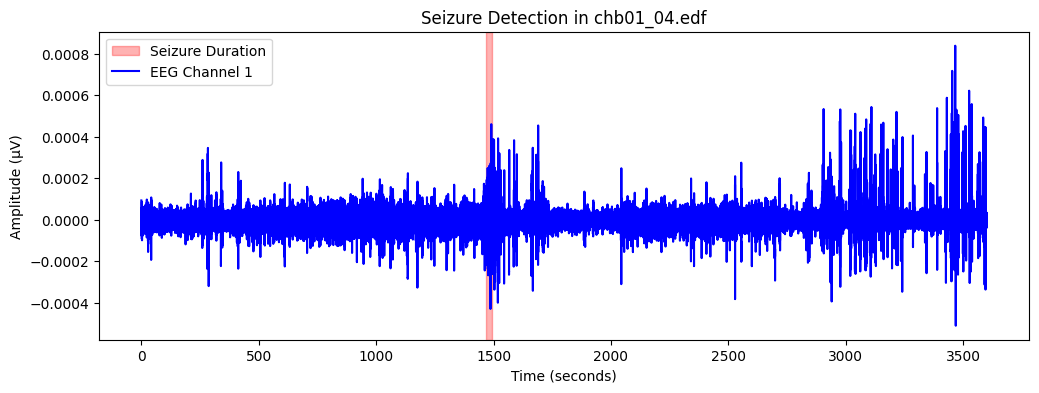

/tmp/ipython-input-289529150.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=False)


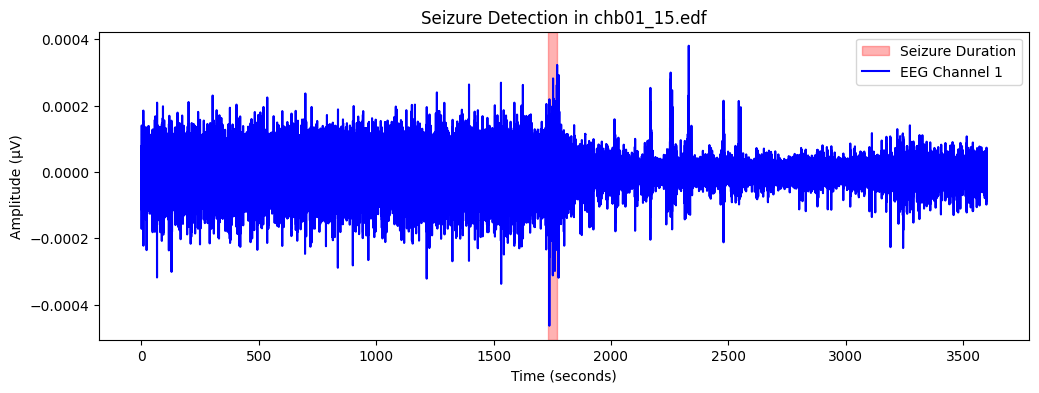

/tmp/ipython-input-289529150.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=False)


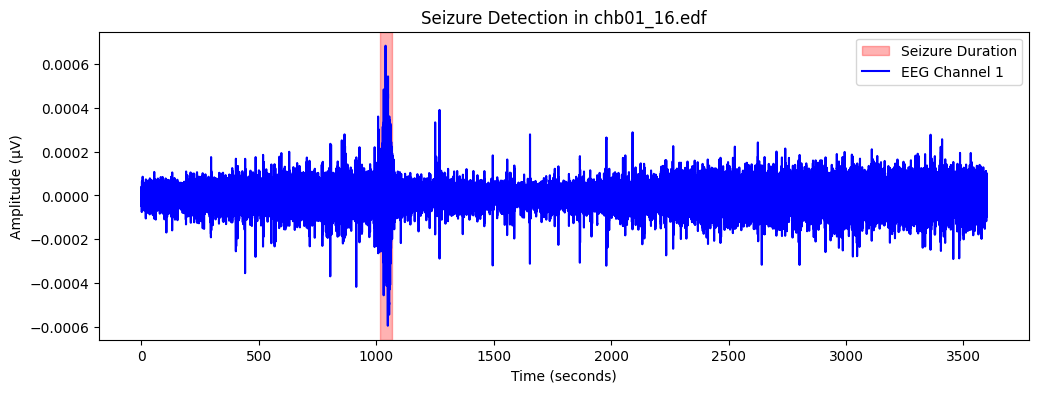

/tmp/ipython-input-289529150.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=False)


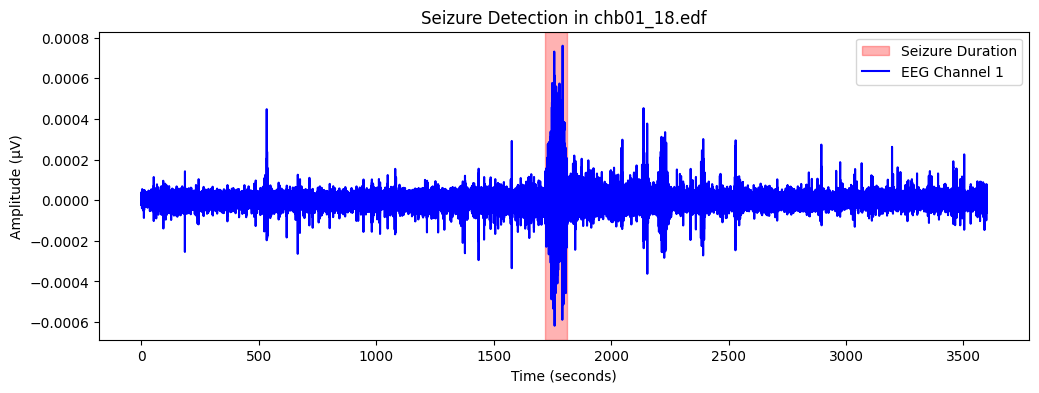

/tmp/ipython-input-289529150.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


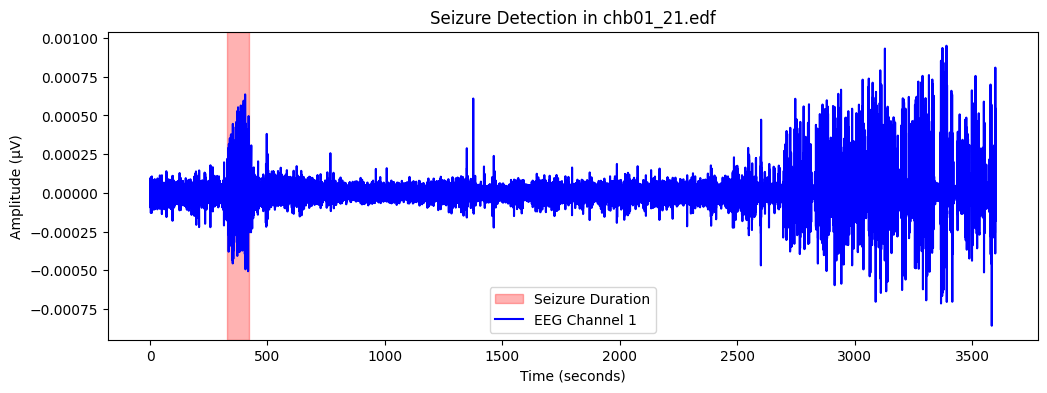

/tmp/ipython-input-289529150.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=False)


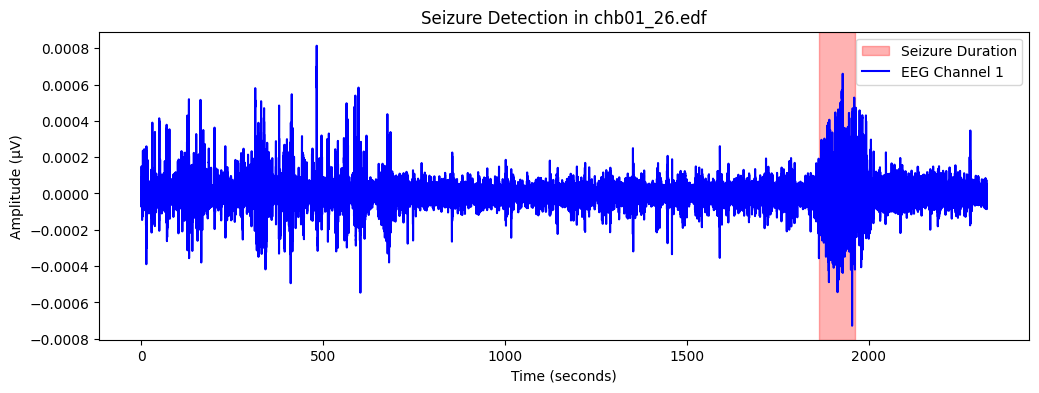

/tmp/ipython-input-289529150.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=False)


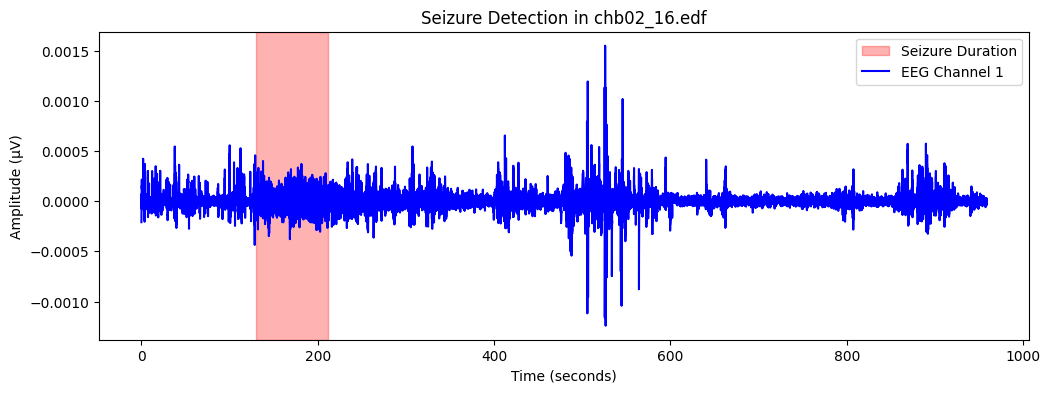

/tmp/ipython-input-289529150.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=False)


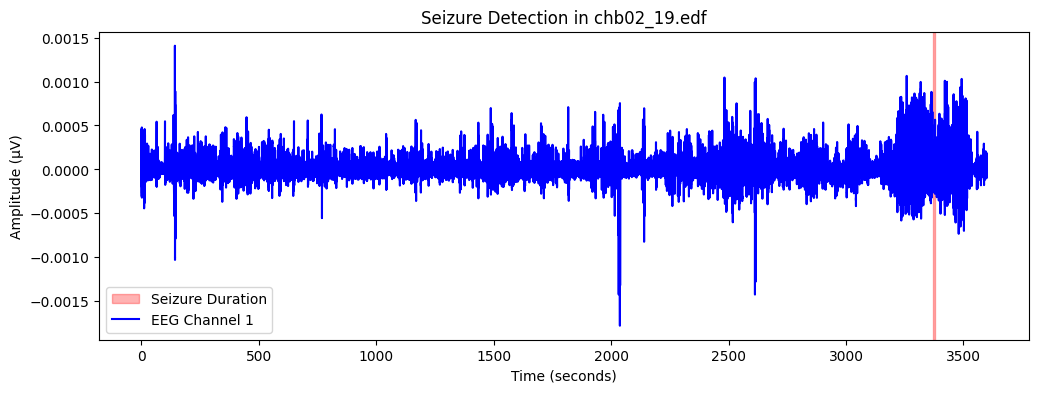

/tmp/ipython-input-289529150.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=False)


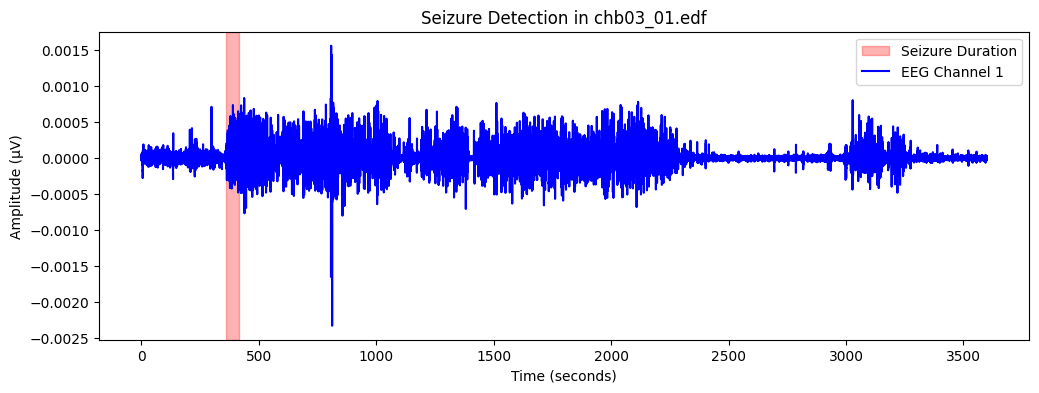

/tmp/ipython-input-289529150.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=False)


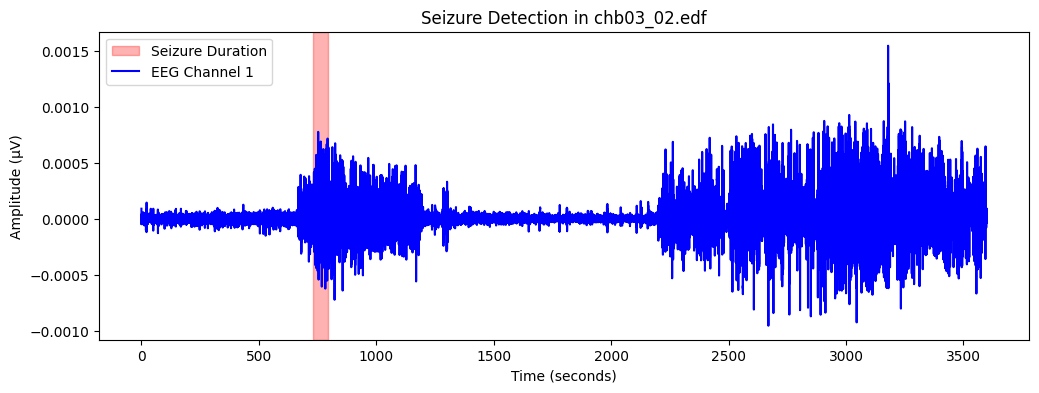

/tmp/ipython-input-289529150.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=False)


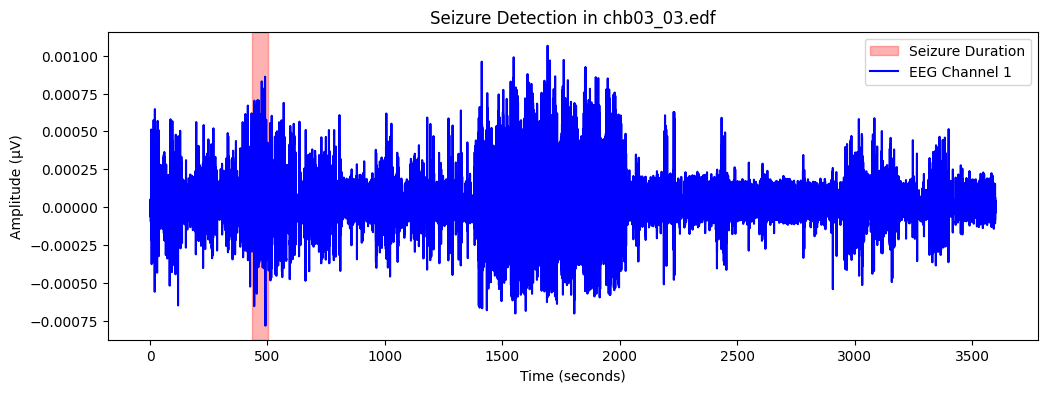

/tmp/ipython-input-289529150.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=False)


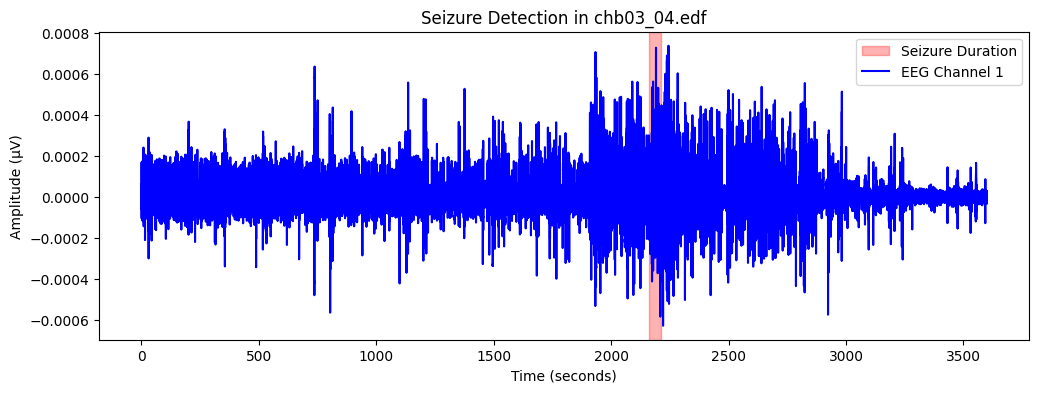

/tmp/ipython-input-289529150.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=False)


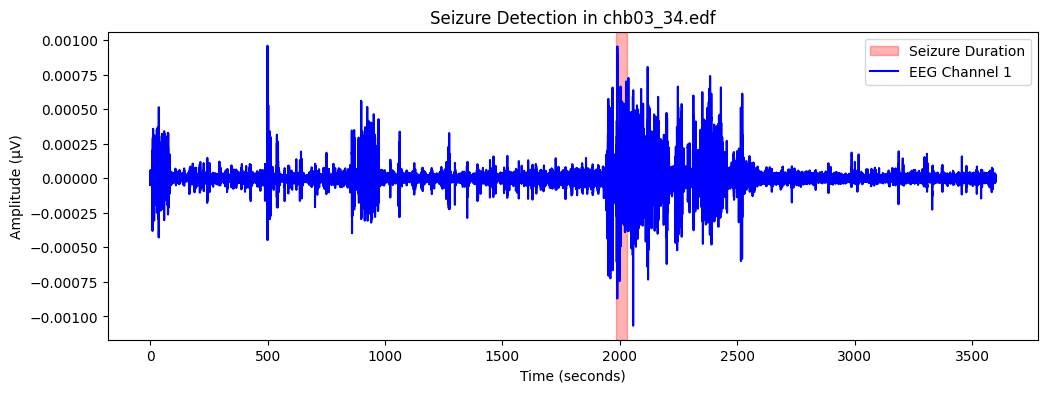

/tmp/ipython-input-289529150.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=False)


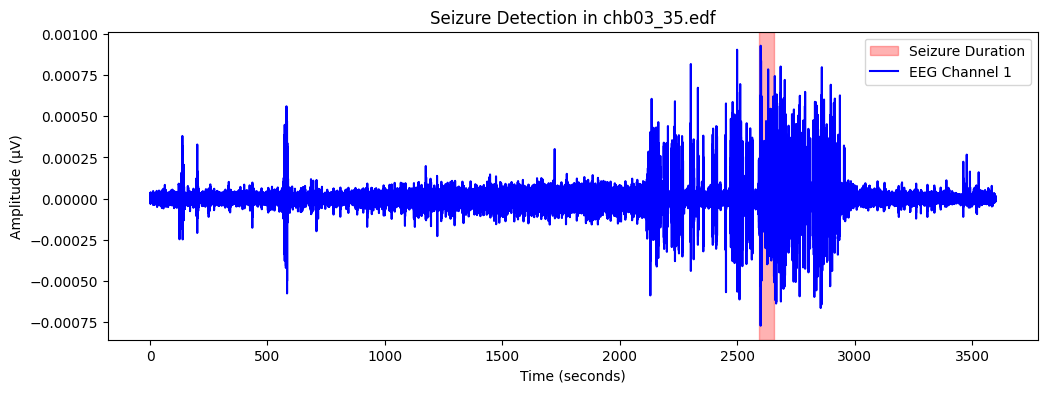

/tmp/ipython-input-289529150.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=False)


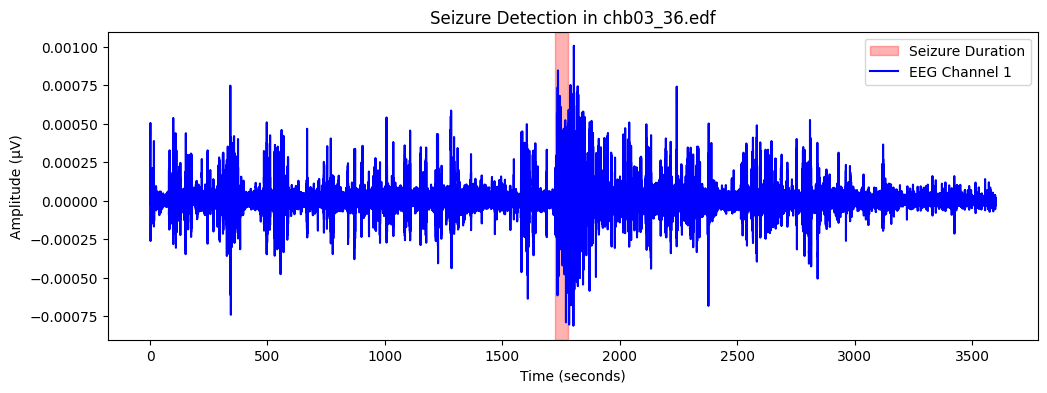

In [11]:
for i, row in df_info.iterrows():
    if row['label'] == 'Seizure Detected':
        file = row['filepath']
        filename = row['filename']
        raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
        data = raw.get_data()
        times = n.arange(data.shape[1]) / raw.info['sfreq']

        start, end = seizure_dict[filename][0]
        plt.figure(figsize=(12, 4))
        plt.axvspan(start, end, color='red', alpha=0.3, label='Seizure Duration')
        plt.plot(times, data[0], label='EEG Channel 1', color='blue')
        plt.title(f"Seizure Detection in {filename}")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude (µV)")
        plt.legend()
        plt.show()


8. Feature Extraction and seperating features and label

In [ ]:
%%capture
filename=[]
features_list = []
labels = []
#for detetcting seizure or no seizure
for i, row in df_info.iterrows():
    try:
        if row['label'] == 'Seizure Detected':
            # Get start and end times from the dictionary
            start_time, end_time = seizure_dict[row['filename']][0]
            feats = extract_features(row['filepath'], start_time=start_time, end_time=end_time)
        else:
            feats = extract_features(row['filepath'])

        filename.append(row['filename'])
        features_list.append(feats)
        labels.append(row['label'])

        #print(f"Processed: {row['filename']}")
    except Exception as e:
        print(f"Error in {row['filename']}: {e}")

X = n.array(features_list)
Y = n.array(labels)
filename=n.array(filename)

#print("\nFeature shape:", X.shape)
#print("Label shape:", Y.shape)

In [ ]:
%%capture
seizure_filename=[]
seizure_feature_list=[]
start=[]
end=[]
#for detecting seizure start and end time of seizure file
for i, row in seizure_info.iterrows():
    try:
        feats_seizure = extract_features(row['filepath'])
        seizure_filename.append(row['filename'])
        seizure_feature_list.append(feats_seizure)
        start.append(row['starting time'])
        end.append(row['ending time'])

        print(f"Processed: {row['filename']}")
    except Exception as e:
        print(f"Error in {row['filename']}: {e}")

X_seizure = n.array(seizure_feature_list)
seizure_filename=n.array(seizure_filename)
start=n.array(start)
end= n.array(end)

9. Spliting Data for Training and Testing purpose

In [ ]:
filename_train, filename_test,X_train, X_test, Y_train, Y_test = train_test_split(filename, X, Y, test_size=0.1, random_state=42, stratify=Y)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)
#print(Y_train)
#print(Y_test)

(103, 1555) (12, 1555) (103,) (12,)


In [ ]:
seizure_filename_train, seizure_filename_test, X_seizure_train, X_seizure_test, start_train, start_test, end_train, end_test = train_test_split(seizure_filename, X_seizure, start, end, test_size=0.1, random_state=42,)
print(X_seizure_train.shape,X_seizure_test.shape,start_train.shape,start_test.shape,end_train.shape,end_test.shape)
#print(Y_train)
#print(Y_test)

(14, 1555) (2, 1555) (14,) (2,) (14,) (2,)


10. Classification to detect Seizures

a. Training model for classification purpose

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

b. Predicting and Checking accuracy of trained data

In [ ]:
y_prediction_train = model.predict(X_train)

train_accuracy = accuracy_score(Y_train, y_prediction_train)
print("Training Accuracy:", round(train_accuracy * 100, 2), "%")

Training Accuracy: 100.0 %


c. Predicting and Checking accuracy of test data

In [ ]:
y_prediction_test = model.predict(X_test)
test_accuracy = accuracy_score(Y_test, y_prediction_test)
print("Testing Accuracy :", round(test_accuracy * 100, 2), "%")

Testing Accuracy : 100.0 %


11. Training the model to detect the start time.

a. Training model to detect start time

In [ ]:
start_model = RandomForestRegressor(n_estimators=100,random_state=42)
start_model.fit(X_seizure_train, start_train)

RandomForestRegressor(random_state=42)

b. Predicting and Checking accuracy of trained data

In [ ]:
start_prediction_train = start_model.predict(X_seizure_train)
mae_train_start = round(mean_absolute_error(start_train, start_prediction_train),2)
print("Training MAE for Start Time:", mae_train_start, "seconds")

Training MAE for Start Time: 349.91 seconds


c. Predicting and Checking accuracy of test data

In [ ]:
start_prediction_test = start_model.predict(X_seizure_test)
mae_test_start = round(mean_absolute_error(start_test, start_prediction_test),2)
print("Testing MAE for Start Time:", mae_test_start, "seconds")

Testing MAE for Start Time: 800.37 seconds


12. Training the model to detect end time

a. Training model to detect end time

In [ ]:
end_model = RandomForestRegressor(n_estimators=100,random_state=42)
end_model.fit(X_seizure_train, end_train)

RandomForestRegressor(random_state=42)

b. Predicting and Checking accuracy of trained data

In [ ]:
end_prediction_train = end_model.predict(X_seizure_train)
mae_train_end = round(mean_absolute_error(end_train, end_prediction_train),2)
print("Training MAE for End Time:", mae_train_end, "seconds")

Training MAE for End Time: 342.67 seconds


c. Predicting and Checking accuracy of test data

In [ ]:
end_prediction_test = end_model.predict(X_seizure_test)
mae_test_end = round(mean_absolute_error(end_test, end_prediction_test),2)
print("Testing MAE for End Time:", mae_test_end, "seconds")

Testing MAE for End Time: 798.4 seconds


13.a Displaying the train result

In [ ]:
#classification result
results_train = p.DataFrame ({
    'File Name': filename_train,
    'Actual Result': Y_train,
    'Predicted Result': y_prediction_train,
})
print('Training Result')
print('Result accuracy=', train_accuracy*100)
from IPython.display import display
display(results_train)

Training Result
Result accuracy= 100.0


,File Name,Actual Result,Predicted Result
0,chb03_35.edf,Seizure Detected,Seizure Detected
1,chb01_21.edf,Seizure Detected,Seizure Detected
2,chb02_03.edf,No Seizure Detected,No Seizure Detected
3,chb03_14.edf,No Seizure Detected,No Seizure Detected
4,chb01_07.edf,No Seizure Detected,No Seizure Detected
...,...,...,...
98,chb03_06.edf,No Seizure Detected,No Seizure Detected
99,chb01_32.edf,No Seizure Detected,No Seizure Detected
100,chb02_22.edf,No Seizure Detected,No Seizure Detected
101,chb03_05.edf,No Seizure Detected,No Seizure Detected


In [ ]:
#regression result
results_train_seizure = p.DataFrame ({
    'File Name': seizure_filename_train,
    'Actual start': start_train,
    'Predicted start': start_prediction_train,
    'Start Difference': abs(start_train-start_prediction_train),
    'Actual end': end_train,
    'Predicted end': end_prediction_train,
    'End Difference': abs(end_train-end_prediction_train),
})
print('Training Result')
print('Start accuracy=', mae_train_start,'seconds')
print('End accuracy=', mae_train_end,'seconds')
from IPython.display import display
display(results_train_seizure)

Training Result
Start accuracy= 349.91 seconds
End accuracy= 342.67 seconds


,File Name,Actual start,Predicted start,Start Difference,Actual end,Predicted end,End Difference
0,chb01_21.edf,327,925.75,598.75,420,1014.91,594.91
1,chb03_35.edf,2592,2133.56,458.44,2656,2207.00,449.00
2,chb03_34.edf,1982,1853.95,128.05,2029,1879.74,149.26
3,chb03_03.edf,432,914.35,482.35,501,966.42,465.42
4,chb02_19.edf,3369,2520.12,848.88,3378,2549.01,828.99
5,chb03_01.edf,362,864.92,502.92,414,871.36,457.36
6,chb01_15.edf,1732,1610.57,121.43,1772,1660.48,111.52
7,chb03_36.edf,1725,1839.10,114.10,1778,1891.92,113.92
8,chb01_18.edf,1720,1767.80,47.80,1810,1835.97,25.97
9,chb02_16.edf,130,735.57,605.57,212,792.80,580.80


File Name: chb01_21.edf
Predicted Seizure Start Time: 925.75 seconds
Predicted Seizure End Time: 1014.91 seconds


/tmp/ipython-input-295559512.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


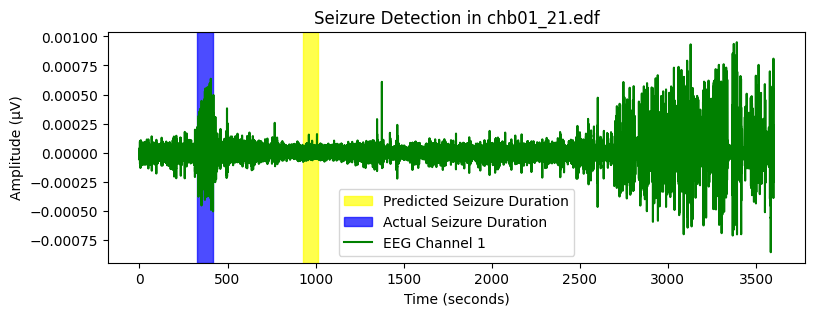

File Name: chb03_35.edf
Predicted Seizure Start Time: 2133.56 seconds
Predicted Seizure End Time: 2207.0 seconds


/tmp/ipython-input-295559512.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


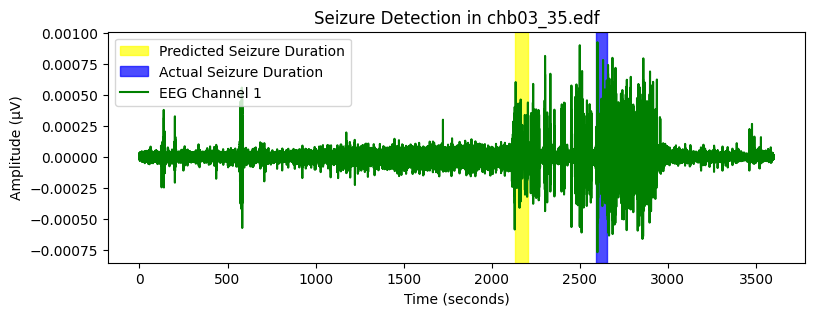

File Name: chb03_34.edf
Predicted Seizure Start Time: 1853.95 seconds
Predicted Seizure End Time: 1879.74 seconds


/tmp/ipython-input-295559512.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


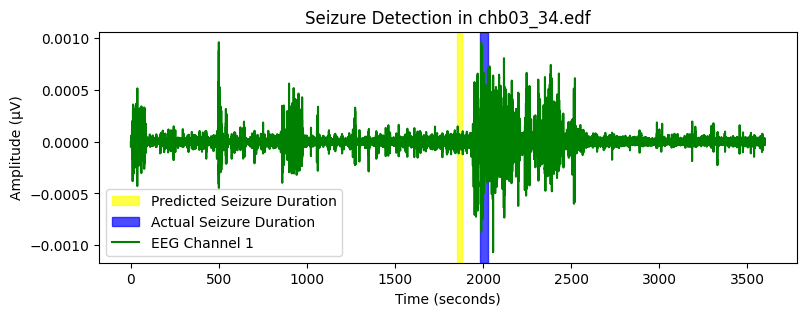

File Name: chb03_03.edf
Predicted Seizure Start Time: 914.35 seconds
Predicted Seizure End Time: 966.42 seconds


/tmp/ipython-input-295559512.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


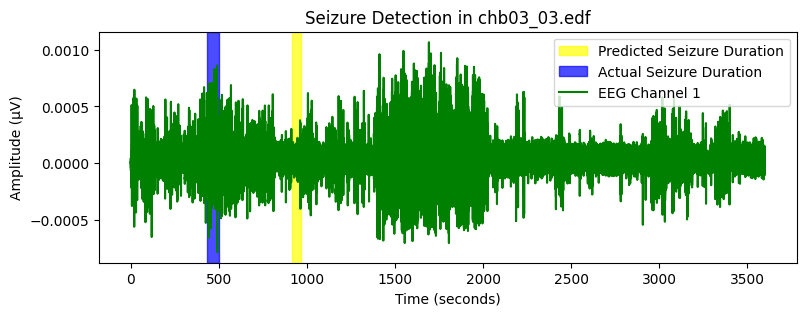

File Name: chb02_19.edf
Predicted Seizure Start Time: 2520.12 seconds
Predicted Seizure End Time: 2549.01 seconds


/tmp/ipython-input-295559512.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


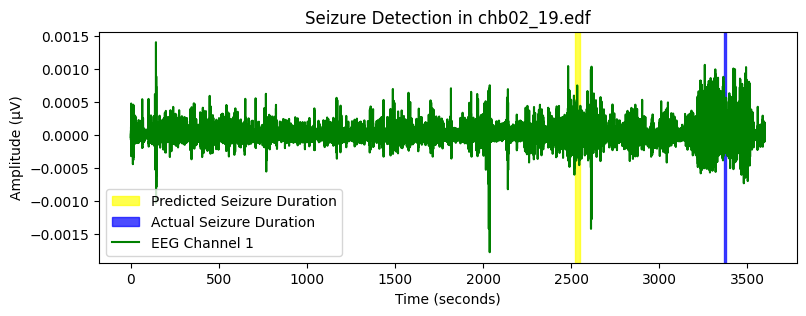

File Name: chb03_01.edf
Predicted Seizure Start Time: 864.92 seconds
Predicted Seizure End Time: 871.36 seconds


/tmp/ipython-input-295559512.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


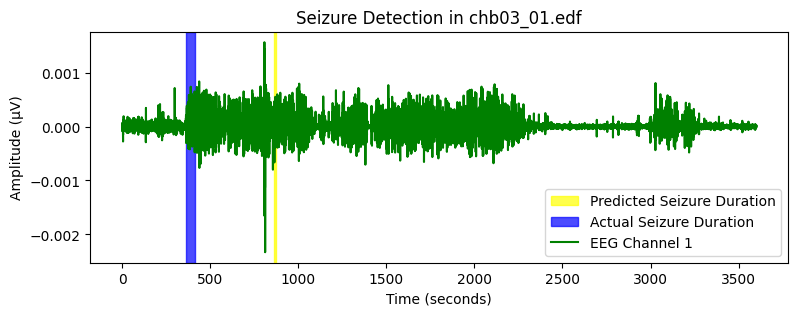

File Name: chb01_15.edf
Predicted Seizure Start Time: 1610.57 seconds
Predicted Seizure End Time: 1660.48 seconds


/tmp/ipython-input-295559512.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


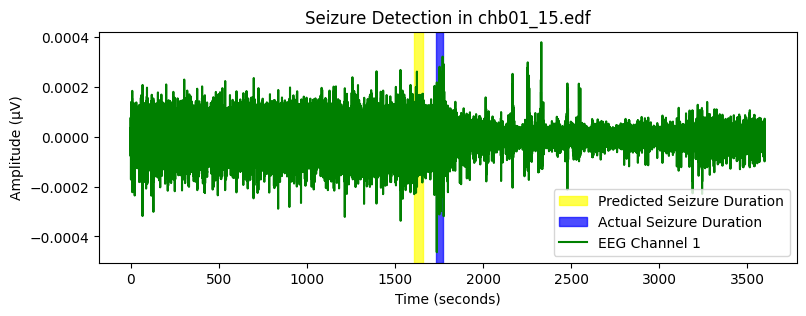

File Name: chb03_36.edf
Predicted Seizure Start Time: 1839.1 seconds
Predicted Seizure End Time: 1891.92 seconds


/tmp/ipython-input-295559512.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


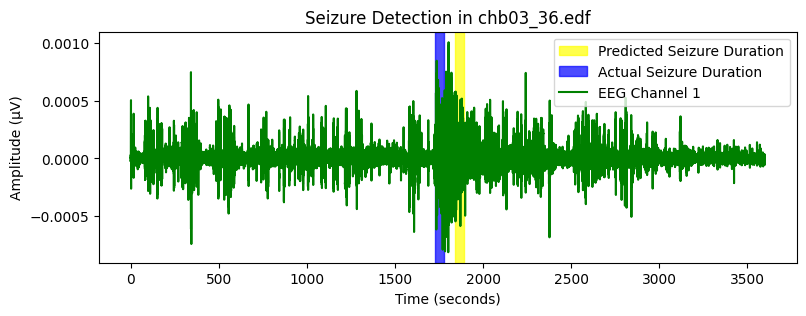

File Name: chb01_18.edf
Predicted Seizure Start Time: 1767.8 seconds
Predicted Seizure End Time: 1835.97 seconds


/tmp/ipython-input-295559512.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


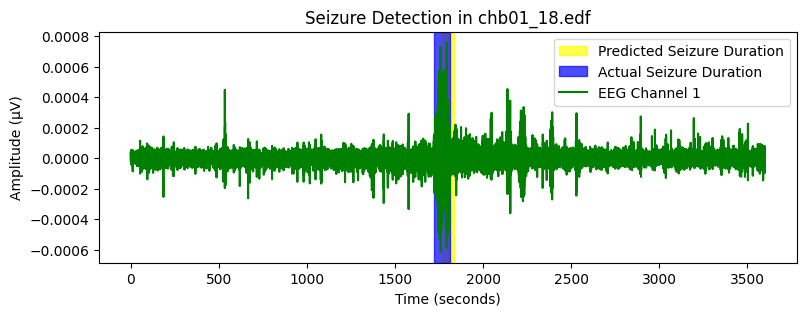

File Name: chb02_16.edf
Predicted Seizure Start Time: 735.57 seconds
Predicted Seizure End Time: 792.8 seconds


/tmp/ipython-input-295559512.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


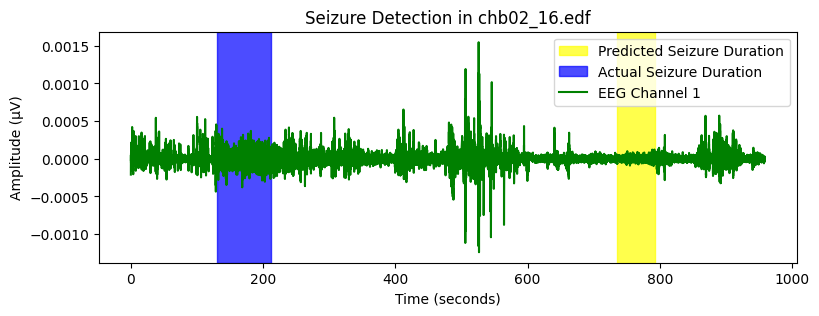

File Name: chb03_02.edf
Predicted Seizure Start Time: 1051.2 seconds
Predicted Seizure End Time: 1131.58 seconds


/tmp/ipython-input-295559512.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


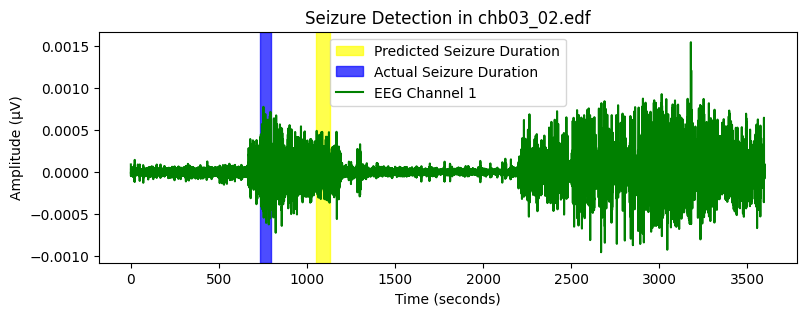

File Name: chb03_04.edf
Predicted Seizure Start Time: 1980.44 seconds
Predicted Seizure End Time: 2040.41 seconds


/tmp/ipython-input-295559512.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


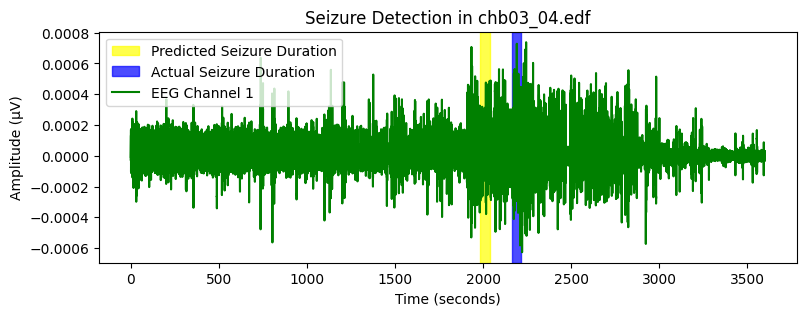

File Name: chb01_16.edf
Predicted Seizure Start Time: 1192.7 seconds
Predicted Seizure End Time: 1253.12 seconds


/tmp/ipython-input-295559512.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


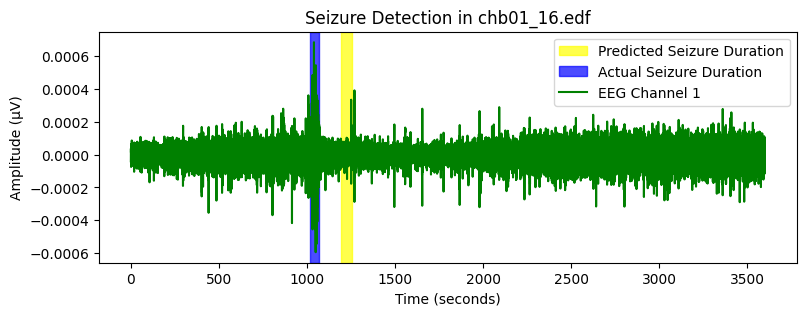

File Name: chb01_26.edf
Predicted Seizure Start Time: 1551.08 seconds
Predicted Seizure End Time: 1639.1 seconds


/tmp/ipython-input-295559512.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


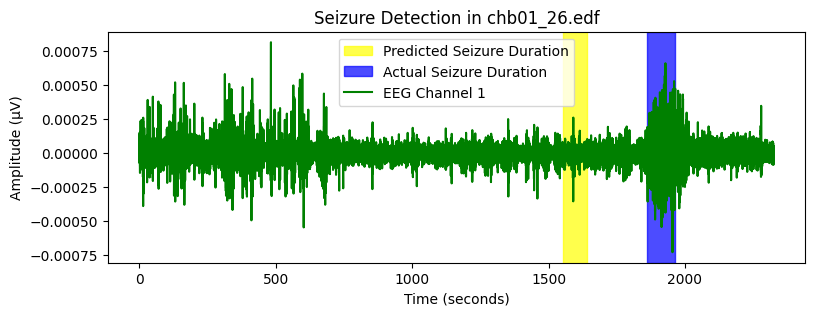

In [ ]:
#Visualization
for i, row in results_train_seizure.iterrows():
        predicted_start = row['Predicted start']
        predicted_end = row['Predicted end']
        file_name = row['File Name']
        actual_start, actual_end = seizure_dict[file_name][0]
        file_path = next((item['filepath'] for item in data_info if item['filename'] == file_name), None)

        if file_path:
            print(f"File Name: {file_name}")
            print(f"Predicted Seizure Start Time: {round(predicted_start, 2)} seconds")
            print(f"Predicted Seizure End Time: {round(predicted_end, 2)} seconds")

            # Visualization for the file
            raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
            data = raw.get_data()
            times = n.arange(data.shape[1]) / raw.info['sfreq']

            plt.figure(figsize=(9, 3))
            plt.axvspan(predicted_start, predicted_end, color='yellow', alpha=0.7, label='Predicted Seizure Duration')
            plt.axvspan(actual_start, actual_end, color='blue', alpha=0.7, label='Actual Seizure Duration')
            plt.plot(times, data[0], label='EEG Channel 1', color='green')
            plt.title(f"Seizure Detection in {file_name}")
            plt.xlabel("Time (seconds)")
            plt.ylabel("Amplitude (µV)")
            plt.legend()
            plt.show()
        else:
            print(f"File not found for {file_name}")

13.b Displaying the test result

In [ ]:
#classification result
results_test = p.DataFrame ({
    'File Name': filename_test,
    'Actual Result': Y_test,
    'Predicted Result': y_prediction_test,
})
print('Testing Result')
print('Result accuracy=', test_accuracy*100)
from IPython.display import display
display(results_test)

Testing Result
Result accuracy= 100.0


,File Name,Actual Result,Predicted Result
0,chb02_18.edf,No Seizure Detected,No Seizure Detected
1,chb03_11.edf,No Seizure Detected,No Seizure Detected
2,chb01_20.edf,No Seizure Detected,No Seizure Detected
3,chb03_08.edf,No Seizure Detected,No Seizure Detected
4,chb01_29.edf,No Seizure Detected,No Seizure Detected
5,chb01_15.edf,Seizure Detected,Seizure Detected
6,chb03_23.edf,No Seizure Detected,No Seizure Detected
7,chb03_19.edf,No Seizure Detected,No Seizure Detected
8,chb03_29.edf,No Seizure Detected,No Seizure Detected
9,chb03_27.edf,No Seizure Detected,No Seizure Detected


In [ ]:
#regression result
results_test_seizure = p.DataFrame ({
    'File Name': seizure_filename_test,
    'Actual start': start_test,
    'Predicted start': start_prediction_test,
    'Start Difference': abs(start_test-start_prediction_test),
    'Actual end': end_test,
    'Predicted end': end_prediction_test,
    'End Difference': abs(end_test-end_prediction_test),
})
print('Testing Result')
print('Start accuracy=', mae_test_start,'seconds')
print('End accuracy=', mae_test_end,'seconds')
from IPython.display import display
display(results_test_seizure)

Testing Result
Start accuracy= 800.37 seconds
End accuracy= 798.4 seconds


,File Name,Actual start,Predicted start,Start Difference,Actual end,Predicted end,End Difference
0,chb01_03.edf,2996,1660.80,1335.20,3036,1762.46,1273.54
1,chb01_04.edf,1467,1732.53,265.53,1494,1817.27,323.27


File Name: chb01_03.edf
Predicted Seizure Start Time: 1660.8 seconds
Predicted Seizure End Time: 1762.46 seconds


/tmp/ipython-input-2705057318.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


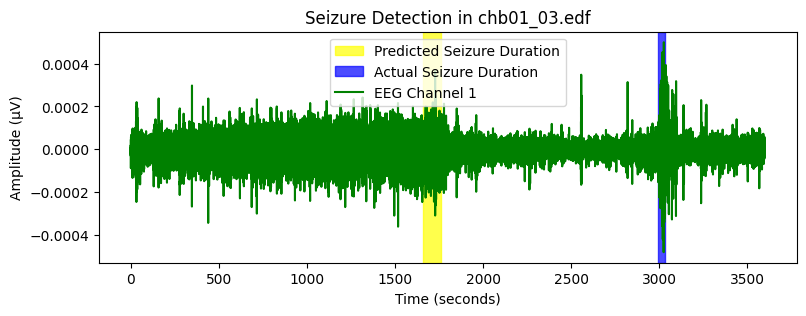

File Name: chb01_04.edf
Predicted Seizure Start Time: 1732.53 seconds
Predicted Seizure End Time: 1817.27 seconds


/tmp/ipython-input-2705057318.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


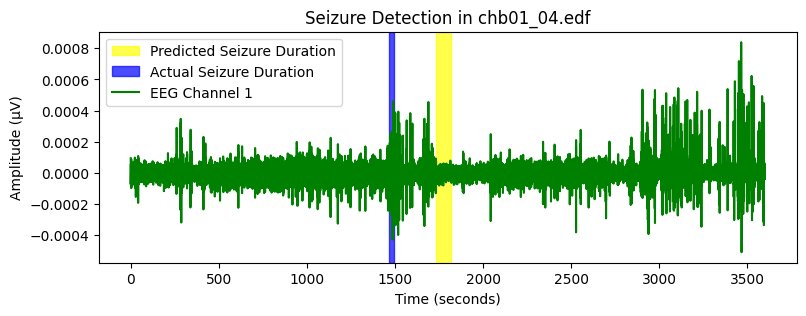

In [ ]:
#Visualization
for i, row in results_test_seizure.iterrows():
        predicted_start = row['Predicted start']
        predicted_end = row['Predicted end']
        file_name = row['File Name']
        actual_start, actual_end = seizure_dict[file_name][0]
        file_path = next((item['filepath'] for item in data_info if item['filename'] == file_name), None)

        if file_path:
            print(f"File Name: {file_name}")
            print(f"Predicted Seizure Start Time: {round(predicted_start, 2)} seconds")
            print(f"Predicted Seizure End Time: {round(predicted_end, 2)} seconds")

            # Visualization for the file
            raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
            data = raw.get_data()
            times = n.arange(data.shape[1]) / raw.info['sfreq']

            plt.figure(figsize=(9, 3))
            plt.axvspan(predicted_start, predicted_end, color='yellow', alpha=0.7, label='Predicted Seizure Duration')
            plt.axvspan(actual_start, actual_end, color='blue', alpha=0.7, label='Actual Seizure Duration')
            plt.plot(times, data[0], label='EEG Channel 1', color='green')
            plt.title(f"Seizure Detection in {file_name}")
            plt.xlabel("Time (seconds)")
            plt.ylabel("Amplitude (µV)")
            plt.legend()
            plt.show()
        else:
            print(f"File not found for {file_name}")

14. Working with completely new data

In [ ]:
#for testing /content/drive/MyDrive/Engineering_Project_1/Patient_5/filename.edf
new_file = input('Please enter the file path of the new EEG file: ')


try:
    raw_new = mne.io.read_raw_edf(new_file, preload=True, verbose=False)
    new_feats = extract_features(new_file).reshape(1, -1)
    prediction = model.predict(new_feats)[0]
    print("\n Prediction Result:")
    if prediction == 'Seizure Detected':
        print("Seizure Detected in this EEG file!")
        start_prediction = start_model.predict(new_feats)[0]
        end_prediction = end_model.predict(new_feats)[0]

        print(f"Predicted Seizure Start Time: {round(start_prediction, 2)} seconds")
        print(f"Predicted Seizure End Time: {round(end_prediction, 2)} seconds")

        # Visualization for the new file
        data_new = raw_new.get_data()
        times_new = n.arange(data_new.shape[1]) / raw_new.info['sfreq']
        filename_new = new_file.split('/')[-1]

        plt.figure(figsize=(12, 4))
        plt.axvspan(start_prediction, end_prediction, color='yellow', alpha=0.7, label='Predicted Seizure Duration')
        plt.plot(times_new, data_new[0], label='EEG Channel 1', color='green')
        plt.title(f"Seizure Detection in {filename_new}")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude (µV)")
        plt.legend()
        plt.show()

    else:
        print("No Seizure Detected in this EEG file.")
        data_new = raw_new.get_data()
        times_new = n.arange(data_new.shape[1]) / raw_new.info['sfreq']
        filename_new = new_file.split('/')[-1]

        plt.figure(figsize=(12, 4))
        plt.plot(times_new, data_new[0], label='EEG Channel 1', color='green')
        plt.title(f"No Seizure Detection in {filename_new}")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude (µV)")
        plt.legend()
        plt.show()

except Exception as e:
    print("⚠️ Error during prediction:", e)